In [5]:
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
from scvi_colab import install
install()
run_outside_colab=True
import scvi
import scipy.sparse
import decoupler as dc
import torch
import gzip
from gtfparse import read_gtf
from pybiomart import Dataset,Server
import os

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
[rank: 0] Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [2]:
############## Read in GENCODE for protein coding genes ################
gencode=read_gtf("../../gencode.v44.annotation.gtf")
protein_coding_genes = list(gencode.gene_name[np.where((gencode.feature=='gene')
            &(gencode.gene_type=='protein_coding')
            )[0]])


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


In [3]:
len(protein_coding_genes)

20046

In [6]:
exc = sc.read('../../HIV_data/single_cell_scorch/exc_v2_updated.h5ad')
exc
#exc.var_names=exc.var_names.str.upper()
#exc.var['gene_ids'] = exc.var_names
#exc.var=exc.var.reset_index(drop=True)
#exc.var_names= exc.var.gene_ids

AnnData object with n_obs × n_vars = 126672 × 45844
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [5]:
exc.var

,gene_ids,n_cells
gene_ids,,
WASH7P,WASH7P,950
MIR1302-2HG,MIR1302-2HG,20
ENSG00000238009,ENSG00000238009,1809
ENSG00000239945,ENSG00000239945,30
CICP27,CICP27,196
...,...,...
MT-ND6,MT-ND6,13038
MT-TE,MT-TE,1905
MT-CYB,MT-CYB,94114


In [6]:
exc = exc[:,np.where(exc.var.isin(protein_coding_genes))[0]]

In [7]:
exc

View of AnnData object with n_obs × n_vars = 126672 × 18468
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [15]:
# Healthy control samples
controls = list(np.where(
    (exc.obs['sample'].str.contains('HCCCY')) |
    (exc.obs['sample'].str.contains('HCCRS')) |
    (exc.obs['sample'].str.contains('HCTGD')) |
    (exc.obs['sample'].str.contains('HCTKN')) |
    (exc.obs['sample'].str.contains('HCTLI')) |
    (exc.obs['sample'].str.contains('HCTMU')) |
    (exc.obs['sample'].str.contains('HCTMW')) |
    (exc.obs['sample'].str.contains('HCTPK')) |
    (exc.obs['sample'].str.contains('HCTTS')) |
    (exc.obs['sample'].str.contains('HCTXJ')) |
    (exc.obs['sample'].str.contains('HCcPL')) |
    (exc.obs['sample'].str.contains('HCtME')) |
    (exc.obs['sample'].str.contains('HCtNZ'))
)[0])

# HIV samples excluding OUD
hiv = list(np.where(
    (exc.obs['sample'].str.contains('10280')) |
    (exc.obs['sample'].str.contains('10288')) |
    (exc.obs['sample'].str.contains('10304')) |
    (exc.obs['sample'].str.contains('10305')) |
    (exc.obs['sample'].str.contains('1068')) |
    (exc.obs['sample'].str.contains('1129')) |
    (exc.obs['sample'].str.contains('1137')) |
    (exc.obs['sample'].str.contains('6801066772')) |
    (exc.obs['sample'].str.contains('6801187468')) |
    (exc.obs['sample'].str.contains('7100518287')) |
    (exc.obs['sample'].str.contains('7101847783')) |
    (exc.obs['sample'].str.contains('7102096765')) |
    (exc.obs['sample'].str.contains('7200776574')) 
)[0])

# HIV samples with ART
hiv_art = list(np.where(
    (exc.obs['sample'].str.contains('010280')) |
    (exc.obs['sample'].str.contains('010288')) |
    (exc.obs['sample'].str.contains('010304')) |
    (exc.obs['sample'].str.contains('010305')) |
    (exc.obs['sample'].str.contains('1129')) |
    (exc.obs['sample'].str.contains('6801066772')) |
    (exc.obs['sample'].str.contains('6801187468')) |
    (exc.obs['sample'].str.contains('7102096765')) |
    (exc.obs['sample'].str.contains('7201068268'))
)[0])

# HIV samples with no ART
hiv_no_art = list(np.where(
    (exc.obs['sample'].str.contains('1068')) |
    (exc.obs['sample'].str.contains('7100518287')) |
    (exc.obs['sample'].str.contains('7101847783')) |
    (exc.obs['sample'].str.contains('7200776574'))
)[0])

In [9]:
exc[np.where((exc[controls].obs.study=='Spudich'))[0]].obs.subclass.value_counts()

subclass
L2-3 IT      12937
L3-5 IT-3     2925
L3-5 IT-2     2756
L3-5 IT-1     2446
L6 IT-1       1684
L6 CT         1257
L6B            909
L5-6 NP        710
L6 IT-2        623
L5 ET           51
Name: count, dtype: int64

In [10]:
exc.var.iloc[:,0]

gene_ids
SAMD11      SAMD11
NOC2L        NOC2L
KLHL17      KLHL17
PLEKHN1    PLEKHN1
PERM1        PERM1
            ...   
MT-ND4L    MT-ND4L
MT-ND4      MT-ND4
MT-ND5      MT-ND5
MT-ND6      MT-ND6
MT-CYB      MT-CYB
Name: gene_ids, Length: 18468, dtype: object

In [11]:
sc.pp.filter_genes(exc, min_cells = 10)
exc

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


AnnData object with n_obs × n_vars = 126672 × 18362
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'study', 'subtype', 'subclass', 'class', 'TopSubclassScore', 'TopClassScore', 'TopSubtypeScore', 'integrated_snn_res.0.5', 'ident', 'n_genes', '_scvi_batch', '_scvi_labels', 'doublet'
    var: 'gene_ids', 'n_cells'
    uns: 'X_name', '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'subclass_colors', 'subtype_colors', 'umap'
    obsm: 'PCA', 'UMAP', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'logcounts'
    obsp: 'connectivities', 'distances'

In [12]:
exc.var.gene_ids.is_unique

True

L6 IT-2
Num Genes:13228
Num cells:916


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [01:50<00:00,  1.82it/s, v_num=1, train_loss_step=8.12e+3, train_loss_epoch=8.56e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████| 200/200 [01:50<00:00,  1.82it/s, v_num=1, train_loss_step=8.12e+3, train_loss_epoch=8.56e+3]


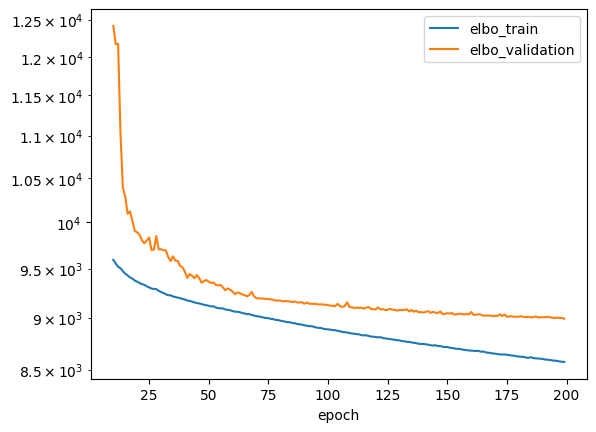

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.12s/it]
L5-6 NP
Num Genes:13816
Num cells:1156


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|████████████████████████████████████████████████████████████████| 200/200 [02:30<00:00,  1.34it/s, v_num=1, train_loss_step=9.33e+3, train_loss_epoch=8.4e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|████████████████████████████████████████████████████████████████| 200/200 [02:30<00:00,  1.33it/s, v_num=1, train_loss_step=9.33e+3, train_loss_epoch=8.4e+3]


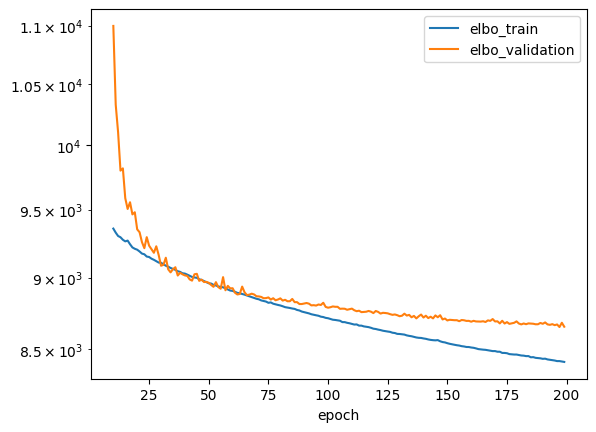

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.08s/it]
L5 ET
Num Genes:10561
Num cells:298


/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /opt/applications/python/3.11.4/gnu/lib/python3.11/s ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/home/ajoshi/.local/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but 

Epoch 200/200: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.08it/s, v_num=1, train_loss_step=7.13e+3, train_loss_epoch=6.7e+3]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.96it/s, v_num=1, train_loss_step=7.13e+3, train_loss_epoch=6.7e+3]


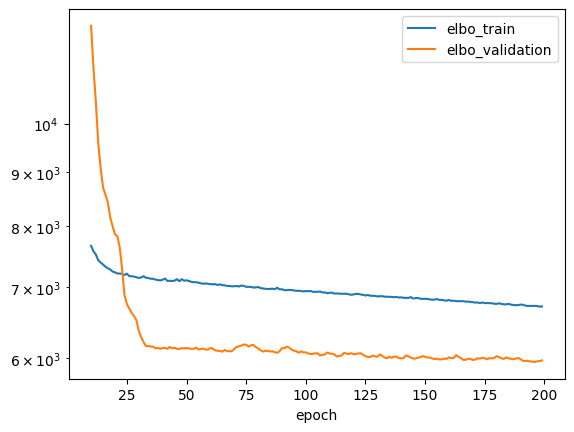

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.80s/it]


In [15]:
##################################################Parameters:##################################
adata_ref_disease = exc[hiv+controls].copy()
results_dir = '../../results/SCORCH_HIV/diff_exp/excitatory/hiv_pos_VS_ctrl/'
cond1 = 'HIV'
cond2 = 'Ctrl'
adata_ref_disease.obs['condition'] = np.where(((adata_ref_disease.obs['sample'].str.contains('HCCCY')) |
    (adata_ref_disease.obs['sample'].str.contains('HCCRS')) | (adata_ref_disease.obs['sample'].str.contains('HCTGD')) | 
    (adata_ref_disease.obs['sample'].str.contains('HCTKN')) | (adata_ref_disease.obs['sample'].str.contains('HCTLI')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTMU')) | (adata_ref_disease.obs['sample'].str.contains('HCTMW')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTPK')) | (adata_ref_disease.obs['sample'].str.contains('HCTTS')) |
    (adata_ref_disease.obs['sample'].str.contains('HCTXJ')) | (adata_ref_disease.obs['sample'].str.contains('HCcPL')) |
    (adata_ref_disease.obs['sample'].str.contains('HCtME')) | (adata_ref_disease.obs['sample'].str.contains('HCtNZ'))
                                         ),cond2,cond1)
#adata_ref_disease.obs['condition'] = np.where(( (adata_ref_disease.obs['sample'].str.contains('1068')) |
 #                                              (adata_ref_disease.obs['sample'].str.contains('7100518287')) | 
  #                                             (adata_ref_disease.obs['sample'].str.contains('7101847783')) |
   #                                            (adata_ref_disease.obs['sample'].str.contains('7200776574'))
    #),'hiv_no_art','hiv_art')
###############################################################################################
#sc.pp.filter_genes(adata_ref_disease, min_cells = 10)
#sc.pp.highly_variable_genes(
 #       adata_ref_disease,
  #      n_top_genes=10000,
   #     subset=True,
    #    flavor="seurat_v3"
     #   )
scvi.model.SCVI.setup_anndata(adata_ref_disease, #layer="UMIs",
                              #categorical_covariate_keys=['Gender'],
                              #continuous_covariate_keys=["Age at Death"]
                             )
model = scvi.model.SCVI(
    adata_ref_disease, gene_likelihood="nb"
    )  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
    max_epochs=300,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
    )
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()

de_change = model.differential_expression(idx1=adata_ref_disease.obs['condition']==cond1,
                                          idx2=adata_ref_disease.obs['condition']==cond2, weights='uniform')

#de = de_change.loc[de_change['is_de_fdr_0.05']==True,:]
de_change["log10_pscore"] = (-1)*np.log10(de_change["proba_not_de"])
de_change.to_csv(results_dir+'allcells_protein_coding.tsv',sep='\t')
#de_change.to_csv(results_dir+'_allcells.tsv',sep='\t')

for cell_type in pd.unique(adata_ref_disease.obs.subclass):
    #if cell_type in ['L2-3 IT', 'L3-5 IT-1', 'L3-5 IT-2','L3-5 IT-3','L6 IT-1','L6 CT', 'L6B']: continue
    
    print(cell_type)
    cells = list(np.where(adata_ref_disease.obs.subclass==cell_type)[0])
    adata_cell = adata_ref_disease[cells].copy()
    sc.pp.filter_genes(adata_cell, min_cells = 10)
    #sc.pp.highly_variable_genes(
     #   adata_cell,
      #  n_top_genes=5000,
       # subset=True,
        #flavor="seurat_v3"
        #)
    print("Num Genes:"+str(len(adata_cell.var)))
    print('Num cells:'+str(len(adata_cell.obs)))
    ####################################Skip the cell type with fewer than 10 cells in each condition#######################
    if (len(np.where(adata_cell.obs['condition']==cond1)[0])<10) or (len(np.where(adata_cell.obs['condition']==cond2)[0])<10):
        continue
    #########################################################################################################################
    scvi.model.SCVI.setup_anndata(adata_cell, #layer="UMIs",
                                  #categorical_covariate_keys=['Gender'],
                                  #continuous_covariate_keys=["Age at Death"]
                                 )
    model = scvi.model.SCVI(
        adata_cell, gene_likelihood="nb")  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
    model.train(
        check_val_every_n_epoch=1,
        max_epochs=200,
        early_stopping=True,
        early_stopping_patience=100,
        early_stopping_monitor="elbo_validation",
        #batch_size=103,
        plan_kwargs={"lr": 0.001}
        )
    train_test_results = model.history["elbo_train"]
    train_test_results["elbo_validation"] = model.history["elbo_validation"]
    train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
    plt.show()
    de_change = model.differential_expression(idx1=adata_cell.obs['condition']==cond1,
                                       idx2=adata_cell.obs['condition']==cond2, weights="uniform")
    
    #de_change = de_change.loc[de['is_de_fdr_0.05']==True,:]
    de_change.loc[:,"log10_pscore"] = (-1)*np.log10(de_change["proba_not_de"])
    cell_type = cell_type.replace('/','')
    cell_type = cell_type.replace(" ","")
    de_change.to_csv(results_dir+cell_type+'_protein_coding.tsv',sep='\t')


# GSEA

In [16]:
gene_sets_to_test = ['GO_Biological_Process_2023','GO_Cellular_Component_2023','GO_Molecular_Function_2023',
                    'WikiPathway_2023_Human',
                    'MSigDB_Hallmark_2020',
                    'KEGG_2021_Human']

In [17]:
file_path_diff_exp = '../../results/SCORCH_HIV/diff_exp/excitatory/hiv_pos_VS_ctrl/'
file_path_gmt = '../../gene_sets/'
gsea_on = 'all_de_genes/'#'all_de_genes' or 'positive_regulated' or 'negative_regulated'
results_dir = '../../results/SCORCH_HIV/gsea/excitatory/'+gsea_on+'hiv_pos_VS_ctrl/'#Make sure correct DEG data frame is read as 'input_gsea'

for file in os.listdir(file_path_diff_exp):
    if 'tsv' in file:
        diff_exp = pd.read_csv(file_path_diff_exp+file, sep='\t',index_col=0)
        diff_exp.loc[:,'sign_lfc']=np.where(diff_exp['lfc_median']<0,-1,1)
        file = file.replace(" ","")
        cell_type = "".join(i for i in file.split('_')[0]).replace('.tsv',"")
        print(cell_type)
        
        ######################## For all DEGs or separate +ve and -ve regulated genes############################
        col = np.where(diff_exp.columns=='log10_pscore')[0]
        diff_exp.loc[:,'metric_gsea'] = diff_exp['log10_pscore']*diff_exp['sign_lfc']
        input_gsea = pd.DataFrame(columns=['metric_gsea'])
        
        if gsea_on=='all_de_genes/':
            input_gsea = diff_exp.loc[:,'metric_gsea']
        #Positive DEGs:
        elif gsea_on=='upreg_genes/':
            input_gsea = diff_exp.iloc[list(np.where(diff_exp['lfc_median']>0)[0]),'metric_gsea']        
        #Negative DEGs
        elif gsea_on=='downreg_genes/':
            input_gsea = diff_exp.iloc[np.where(diff_exp.lfc_median<0)[0],'metric_gsea']

        input_gsea = input_gsea.sort_values(ascending=False)
        gsea_all_paths = pd.DataFrame()
        
        ## Exception handling for when the gmt gene set is irrelevant for the differentially expressed genes
        try:
            gsea_result = gseapy.prerank(rnk=input_gsea, gene_sets=gene_sets_to_test, organism='human')
        except LookupError:
            continue
        #filtered_sets = gsea_result.res2d.iloc[
                                            #np.where((gsea_result.res2d['NOM p-val']<=0.05)&
                                                    #(gsea_result.res2d['FDR q-val']<=0.25))[0]
                                            #,:]
        filtered_sets = gsea_result.res2d
        if len(filtered_sets)>0:
            gsea_all_paths = pd.concat([gsea_all_paths,filtered_sets]).reset_index(drop=True)
            gsea_all_paths=gsea_all_paths.drop_duplicates()
            gsea_all_paths.to_csv(results_dir+cell_type+'.tsv', sep='\t',index=False)

2024-06-08 13:47:55,098 [WARNING] Duplicated values found in preranked stats: 75.33% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L6B


2024-06-08 13:57:11,324 [WARNING] Duplicated values found in preranked stats: 75.40% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L2-3IT


2024-06-08 14:08:48,788 [WARNING] Duplicated values found in preranked stats: 73.62% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L3-5IT-3


2024-06-08 14:19:25,324 [WARNING] Duplicated values found in preranked stats: 73.43% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L6IT-1


2024-06-08 14:29:13,165 [WARNING] Duplicated values found in preranked stats: 74.12% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L6IT-2


2024-06-08 14:36:41,604 [WARNING] Duplicated values found in preranked stats: 72.56% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L6CT


2024-06-08 14:44:27,335 [WARNING] Duplicated values found in preranked stats: 75.80% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


allcells


2024-06-08 14:57:15,140 [WARNING] Duplicated values found in preranked stats: 74.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L5-6NP


2024-06-08 15:05:16,680 [WARNING] Duplicated values found in preranked stats: 72.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L3-5IT-2


2024-06-08 15:15:33,882 [WARNING] Duplicated values found in preranked stats: 70.81% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L5ET


2024-06-08 15:20:49,980 [WARNING] Duplicated values found in preranked stats: 74.39% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


L3-5IT-1


## Read in all DEGs

In [1]:
def get_all_DEG(file_path_diff_exp):
    all_DEG = pd.DataFrame()
    for file in os.listdir(file_path_diff_exp):
        if 'tsv' in file and 'lfc' not in file and 'allcells' not in file:
            diff_exp = pd.read_csv(file_path_diff_exp+file, sep='\t',index_col=0)
            file = file.replace(" ","")
            cell_type = "".join(i for i in file.split('_')[0]).replace('.tsv',"")
            diff_exp.loc[:,'cell_type'] = cell_type
            diff_exp = diff_exp.reset_index().rename(columns={"index":'gene'})
        
            ######For numerical stability: replace infinite values with twice of maximum
            max_twice = diff_exp.loc[diff_exp['log10_pscore'] != np.inf, 'log10_pscore'].max()*2
            diff_exp['log10_pscore'].replace(np.inf,max_twice,inplace=True)
                
            #volcano(diff_exp,cell_type, file_path_diff_exp)
            all_DEG = pd.concat([all_DEG,diff_exp]) #Read in and saved in a previous run is used further in the volcano plot function
    all_DEG = all_DEG.reset_index(drop=True)
    return all_DEG

In [2]:
def get_selection_metric(df):
    selection_metric = df['bayes_factor'] * abs(df['lfc_median'])
    df.loc[:,'selection_metric'] = selection_metric
    return df

In [3]:
def consensus_degs(all_deg_frame,direction):
    consensus_genes=[]
    for gene in pd.unique(all_deg_frame.loc[np.where(all_deg_frame['is_de_fdr_0.05']==True)[0],'gene_ids']):
        if gene not in consensus_genes:
            if direction=='up':
                temp = all_deg_frame.iloc[np.where((all_deg_frame.gene_ids==gene)&(all_deg_frame['is_de_fdr_0.05']==True)
                                                   &(all_deg_frame['lfc_median']>0)
                )[0],:]
            elif direction=='down':
                temp = all_deg_frame.iloc[np.where((all_deg_frame.gene_ids==gene)&(all_deg_frame['is_de_fdr_0.05']==True)
                                                   &(all_deg_frame['lfc_median']<0)
                )[0],:]
            if len(temp) >= 2:
                consensus_genes.append(gene)
    return consensus_genes

In [7]:
all_deg_exc = get_all_DEG('../../results/SCORCH_HIV/diff_exp/excitatory/hiv_pos_VS_ctrl/')
all_deg_exc = get_selection_metric(all_deg_exc)

In [8]:
all_deg_exc

,gene_ids,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric
0,GPIHBP1,0.9692,0.0308,3.448956,1.399616e-06,1.309034e-07,0.0,0.25,3.340018,3.356596,...,0.011889,0.000650,0.011889,0.000650,0.012583,0.000336,True,1.511449,L6B,11.576752
1,HYAL4,0.9674,0.0326,3.390299,2.539436e-06,2.598676e-07,0.0,0.25,3.342821,3.395307,...,0.029062,0.001949,0.022457,0.001949,0.021331,0.001158,True,1.486782,L6B,11.511109
2,OR2H2,0.9668,0.0332,3.371441,3.009980e-07,8.112079e-07,0.0,0.25,-2.650772,-2.991594,...,0.003963,0.009097,0.003963,0.009097,0.002534,0.008100,True,1.478862,L6B,10.085985
3,MCHR1,0.9654,0.0346,3.328689,1.494207e-07,1.080442e-06,0.0,0.25,-3.034580,-3.089656,...,0.001321,0.007797,0.001321,0.006498,0.001090,0.012459,True,1.460924,L6B,10.284502
4,TRAF3IP3,0.9652,0.0348,3.322718,4.267997e-07,9.735663e-07,0.0,0.25,-2.446220,-2.705559,...,0.007926,0.014945,0.006605,0.014945,0.004197,0.010781,True,1.458421,L6B,8.989808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146791,TBC1D5,0.3288,0.6712,-0.713617,5.281596e-04,5.375743e-04,0.0,0.25,-0.023406,-0.037043,...,5.402959,4.759679,0.929553,0.890431,5.294722,5.194910,False,0.173148,L3-5IT-1,-0.026434
146792,PPP2R5E,0.3210,0.6790,-0.749180,1.845926e-04,1.902423e-04,0.0,0.25,-0.042941,-0.045373,...,1.698485,1.620161,0.724199,0.689554,1.690653,1.781959,False,0.168130,L3-5IT-1,-0.033993
146793,TBCK,0.2898,0.7102,-0.896356,3.273398e-04,3.074567e-04,0.0,0.25,0.090514,0.077220,...,3.206059,2.691381,0.877774,0.804967,3.198486,2.971073,False,0.148619,L3-5IT-1,-0.069217
146794,AAK1,0.2480,0.7520,-1.109308,3.593666e-04,3.595671e-04,0.0,0.25,-0.001528,0.005014,...,3.741106,3.380570,0.923917,0.841125,3.777989,3.676878,False,0.123782,L3-5IT-1,-0.005563


In [9]:
consensus_genes_up=consensus_degs(all_deg_exc,'up')

In [10]:
len(consensus_genes_up)

113

In [11]:
consensus_genes_down=consensus_degs(all_deg_exc,'down')
len(consensus_genes_down)

377

In [12]:
set(consensus_genes_up).intersection(consensus_genes_down)

{'ADARB2', 'CHST3', 'CPED1', 'EMX2', 'MT-ATP6', 'RGS1', 'SLC5A8'}

In [23]:
all_deg_exc.loc[np.where(
    #(all_deg_exc.gene_ids.isin(consensus_genes_down))&
    (all_deg_exc['is_de_fdr_0.05']==True)&(all_deg_exc.gene_ids.str.contains('SLC5A8'))
)[0],:]

,gene_ids,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,log10_pscore,cell_type,selection_metric
32243,SLC5A8,0.9430,0.0570,2.806015,6.883992e-07,1.132041e-06,0.0,0.25,-0.691233,-0.822853,...,0.006114,0.006980,0.004785,0.006557,0.007419,0.015089,True,1.244125,L3-5IT-3,2.308938
48299,SLC5A8,0.9654,0.0346,3.328689,3.817515e-06,4.061244e-06,0.0,0.25,-1.303193,-1.532006,...,0.015713,0.016125,0.012571,0.011398,0.037181,0.041764,True,1.460924,L6IT-1,5.099572
77013,SLC5A8,0.9480,0.0520,2.903111,1.932766e-05,9.887871e-06,0.0,0.25,1.575181,1.674845,...,0.183771,0.085391,0.131265,0.061728,0.193302,0.087933,True,1.283997,L6CT,4.862261
130758,SLC5A8,0.9646,0.0354,3.305001,7.533549e-07,3.549067e-07,0.0,0.25,1.545407,1.563970,...,0.007045,0.005478,0.005636,0.004018,0.007427,0.004000,True,1.450997,L3-5IT-1,5.168922


In [111]:
all_deg_exc.loc[np.where(
    (all_deg_exc.gene_ids.isin(consensus_genes_down))&(all_deg_exc['is_de_fdr_0.05']==True)&(all_deg_exc.gene_ids.str.contains('FYB1'))
)[0],['gene_ids','lfc_median','is_de_fdr_0.05','cell_type']].reset_index(drop=True)

,gene_ids,lfc_median,is_de_fdr_0.05,cell_type
0,FYB1,-0.270583,True,L3-5IT-3
1,FYB1,-1.604429,True,L6IT-1
2,FYB1,1.289553,True,L6IT-2
3,FYB1,0.287579,True,L6CT
4,FYB1,0.317293,True,L3-5IT-2
5,FYB1,-0.514933,True,L3-5IT-1


In [131]:
consensus_genes_down

['PENK',
 'VGF',
 'OR2H2',
 'CRH',
 'TMEFF1',
 'G0S2',
 'VCAN',
 'HPR',
 'SST',
 'EMC6',
 'LY6D',
 'CYP2J2',
 'GARIN6',
 'SDF2L1',
 'ST8SIA2',
 'KDR',
 'ITGA2',
 'TMEM63A',
 'UGT8',
 'TAC1',
 'VIP',
 'LGALS1',
 'PI16',
 'VAV3',
 'MOG',
 'DOCK5',
 'TMSB4Y',
 'NPY',
 'VRK2',
 'OLIG2',
 'SLCO1A2',
 'SPDYE2',
 'ZNF536',
 'DCC',
 'FGFR2',
 'ARX',
 'COL4A2',
 'NXPH1',
 'ST18',
 'TOX3',
 'KCNH8',
 'COL4A5',
 'GRIK1',
 'FRMD4B',
 'FA2H',
 'RFTN2',
 'SCO2',
 'HBQ1',
 'POLR2L',
 'DCTPP1',
 'BCAS1',
 'APRT',
 'FAM107B',
 'TAL1',
 'RGS10',
 'FBXL7',
 'ARHGAP42',
 'KIAA1755',
 'IKZF1',
 'NUDT1',
 'SLC1A3',
 'TMEM235',
 'IRF8',
 'LPAR1',
 'LAGE3',
 'THSD7A',
 'COX7A1',
 'SYK',
 'MIF',
 'CCK',
 'CPB1',
 'MET',
 'MKRN3',
 'PRELID1',
 'CLDN1',
 'DAAM2',
 'NGF',
 'RARRES2',
 'EBF1',
 'ETV1',
 'HCRTR1',
 'SPRY4',
 'ADRA1D',
 'KRT5',
 'ADM5',
 'TTC9B',
 'KRT17',
 'LORICRIN',
 'SMOC2',
 'COX8A',
 'CMTM5',
 'PVALB',
 'CORT',
 'VIPR2',
 'BEND4',
 'PHLDA2',
 'GNG3',
 'MICOS13',
 'ANAPC15',
 'COL11A1',
 'NUDT1

/opt/applications/python/3.11.4/gnu/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


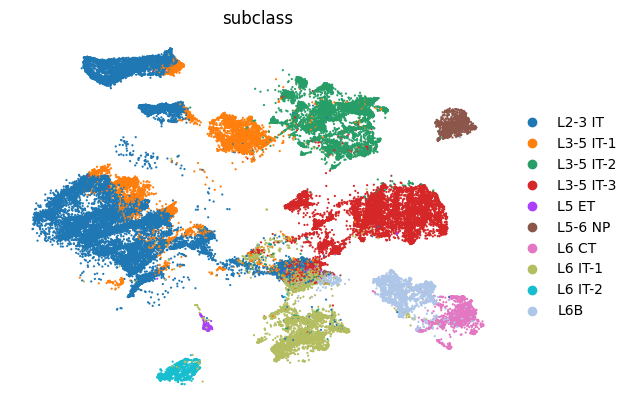

In [16]:
sc.pl.umap(
    exc[controls+hiv],
    color=["subclass"],
    frameon=False,
    size=10
)

In [ ]:
sc.pl.umap(
    exc[hiv],
    color=["NEUROD6"],
    frameon=False,
    size=10,cmap='Reds'
)
sc.pl.umap(
    exc[controls],
    color=["NEUROD6"],
    frameon=False,
    size=10,cmap='Reds'
)

In [137]:
exc.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.0.5,seurat_clusters,study,...,class,TopSubclassScore,TopClassScore,TopSubtypeScore,integrated_snn_res.0.5,ident,n_genes,_scvi_batch,_scvi_labels,doublet
HSB106_1_AAACCCAAGTCGCCCA-1,SeuratProject,8412.0,3535,HSB106_1,0.332858,4020.0,2562,6,10,Sestan,...,ExN,0.963544,0.995521,0.587505,10,10,3535,0,0,singlet
HSB106_1_AAACCCACAAAGGAGA-1,SeuratProject,16512.0,5922,HSB106_1,0.968992,3375.0,2193,2,1,Sestan,...,ExN,0.856520,0.856520,0.683236,1,1,5922,0,0,singlet
HSB106_1_AAACGAACACTGCATA-1,SeuratProject,24614.0,6337,HSB106_1,0.219387,3480.0,1959,2,1,Sestan,...,ExN,0.921001,0.921620,0.623190,1,1,6337,0,0,singlet
HSB106_1_AAACGAATCATCCTAT-1,SeuratProject,16531.0,4804,HSB106_1,0.744057,3438.0,1742,15,13,Sestan,...,ExN,0.987490,0.988098,0.526954,13,13,4804,0,0,singlet
HSB106_1_AAACGCTAGGGTTAAT-1,SeuratProject,16739.0,5660,HSB106_1,0.896111,3349.0,2039,14,4,Sestan,...,ExN,0.840758,0.841768,0.840758,4,4,5660,0,0,singlet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIH1308_08_BA9-FC_TTTATGGAGGCTACTG-1,SeuratProject,2281.0,1477,NIH1308_08_BA9-FC,0.394564,3041.0,1474,5,2,Kellis,...,ExN,0.501861,0.646771,0.353106,2,2,1477,0,0,singlet
NIH1308_08_BA9-FC_TTTCCGGGTAATGACT-1,SeuratProject,12148.0,3923,NIH1308_08_BA9-FC,1.078367,3765.0,1925,5,4,Kellis,...,ExN,0.885929,0.919125,0.885929,4,4,3923,0,0,singlet
NIH1308_08_BA9-FC_TTTCCTGAGCTACTGG-1,SeuratProject,11407.0,3869,NIH1308_08_BA9-FC,0.227930,3782.0,1945,11,13,Kellis,...,ExN,0.986345,0.986821,0.523033,13,13,3869,0,0,singlet
NIH1308_08_BA9-FC_TTTCTTGCATTAGCGC-1,SeuratProject,7802.0,3237,NIH1308_08_BA9-FC,0.922840,4438.0,2777,11,13,Kellis,...,ExN,0.967813,0.977627,0.427515,13,13,3237,0,0,singlet


In [18]:
pseudobulk_adata = dc.get_pseudobulk(
    exc[controls+hiv],
    sample_col='sample',
    groups_col='subclass',
    #layer='UMIs',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pseudobulk_adata

AnnData object with n_obs × n_vars = 236 × 18355
    obs: 'orig.ident', 'sample', 'study', 'subclass', 'class', '_scvi_batch', '_scvi_labels', 'doublet', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'n_cells'
    layers: 'psbulk_props'

In [19]:
pseudobulk_adata.obs

,orig.ident,sample,study,subclass,class,_scvi_batch,_scvi_labels,doublet,psbulk_n_cells,psbulk_counts
10280_HIV_PFC_L2-3 IT,SeuratProject,10280_HIV_PFC,Spudich,L2-3 IT,ExN,0,0,singlet,4439.0,35434092.0
10288_HIV_PFC_L2-3 IT,SeuratProject,10288_HIV_PFC,Spudich,L2-3 IT,ExN,0,0,singlet,419.0,1933556.0
10304_HIV_PFC_L2-3 IT,SeuratProject,10304_HIV_PFC,Spudich,L2-3 IT,ExN,0,0,singlet,625.0,5438592.0
10305_HIV_PFC_L2-3 IT,SeuratProject,10305_HIV_PFC,Spudich,L2-3 IT,ExN,0,0,singlet,884.0,4088862.0
1068_HIV_PFC_L2-3 IT,SeuratProject,1068_HIV_PFC,Spudich,L2-3 IT,ExN,0,0,singlet,1883.0,18356442.0
...,...,...,...,...,...,...,...,...,...,...
HCTTS_CTR_PFC_MAH_L6B,SeuratProject,HCTTS_CTR_PFC_MAH,Spudich,L6B,ExN,0,0,singlet,16.0,134462.0
HCTXJ_CTR_PFC_L6B,SeuratProject,HCTXJ_CTR_PFC,Spudich,L6B,ExN,0,0,singlet,146.0,1273016.0
HCcPL_CTR_PFC_MAH_L6B,SeuratProject,HCcPL_CTR_PFC_MAH,Spudich,L6B,ExN,0,0,singlet,240.0,589102.0
HCtME_CTR_PFC_MAH_L6B,SeuratProject,HCtME_CTR_PFC_MAH,Spudich,L6B,ExN,0,0,singlet,68.0,1207252.0


In [20]:
pbulk_controls = list(np.where(
(pseudobulk_adata.obs['sample'].str.contains('CTR'))
)[0])


################ HIV samples ####################
pbulk_hiv = list(np.where(
(pseudobulk_adata.obs['sample'].str.contains('HIV'))
)[0])

In [21]:
pd.DataFrame(data=pseudobulk_adata.X[pbulk_controls],
             columns=pseudobulk_adata.var.iloc[:,0],
             index=pseudobulk_adata.obs.index[pbulk_controls]).T.to_csv('../../HIV_data/single_cell_scorch/exc_v2_pbulk_controls.tsv',sep='\t')

pd.DataFrame(data=pseudobulk_adata.X[pbulk_hiv],
             columns=pseudobulk_adata.var.iloc[:,0],
             index=pseudobulk_adata.obs.index[pbulk_hiv]).T.to_csv('../../HIV_data/single_cell_scorch/exc_v2_pbulk_hiv.tsv',sep='\t')


In [22]:
pd.DataFrame(data=pseudobulk_adata.X[pbulk_controls],
             columns=pseudobulk_adata.var.iloc[:,0],
             index=pseudobulk_adata.obs.index[pbulk_controls]).T

,HCCCY_CTR_PFC_L2-3 IT,HCCRS_CTR_PFC_L2-3 IT,HCTGD_CTR_PFC_L2-3 IT,HCTKN_CTR_PFC_MAH_L2-3 IT,HCTLI_CTR_PFC_L2-3 IT,HCTMU_CTR_PFC_L2-3 IT,HCTMW_CTR_PFC_MAH_L2-3 IT,HCTPK_CTR_PFC_L2-3 IT,HCTTS_CTR_PFC_MAH_L2-3 IT,HCTXJ_CTR_PFC_L2-3 IT,...,HCTKN_CTR_PFC_MAH_L6B,HCTLI_CTR_PFC_L6B,HCTMU_CTR_PFC_L6B,HCTMW_CTR_PFC_MAH_L6B,HCTPK_CTR_PFC_L6B,HCTTS_CTR_PFC_MAH_L6B,HCTXJ_CTR_PFC_L6B,HCcPL_CTR_PFC_MAH_L6B,HCtME_CTR_PFC_MAH_L6B,HCtNZ_CTR_PFC_MAH_L6B
gene_ids,,,,,,,,,,,,,,,,,,,,,
A1BG,9.0,3.0,8.0,2.0,4.0,2.0,10.0,0.0,9.0,47.0,...,1.0,0.0,3.0,2.0,2.0,0.0,7.0,1.0,2.0,1.0
A1CF,0.0,1.0,2.0,0.0,2.0,1.0,2.0,0.0,2.0,11.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,5.0,1.0
A2M,61.0,9.0,25.0,8.0,55.0,1.0,23.0,0.0,52.0,208.0,...,5.0,47.0,7.0,7.0,4.0,0.0,16.0,13.0,11.0,27.0
A2ML1,17.0,3.0,11.0,2.0,13.0,4.0,13.0,0.0,9.0,96.0,...,1.0,10.0,4.0,3.0,5.0,2.0,2.0,3.0,0.0,5.0
A3GALT2,0.0,2.0,6.0,0.0,2.0,2.0,2.0,0.0,6.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,3.0,3.0,4.0,1.0,1.0,2.0,1.0,0.0,1.0,8.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ZYG11B,689.0,117.0,321.0,169.0,326.0,367.0,395.0,65.0,632.0,1738.0,...,123.0,200.0,245.0,174.0,327.0,23.0,110.0,63.0,92.0,333.0
ZYX,100.0,22.0,36.0,25.0,69.0,45.0,59.0,7.0,162.0,229.0,...,4.0,28.0,26.0,16.0,26.0,0.0,18.0,5.0,16.0,44.0


In [24]:
temp = pd.DataFrame(data=pseudobulk_adata.X[pbulk_controls],
             columns=pseudobulk_adata.var.iloc[:,0],
             index=pseudobulk_adata.obs.index[pbulk_controls]).T
lst=['NEUROD1', 'NEUROD2','NEUROD4','NEUROD6','AUTS2','ATRX','TRIB3','HES1','HES2','HES3','HES4','HES5','HES6','HES7']
set(temp.index).intersection(lst)

{'ATRX',
 'AUTS2',
 'HES1',
 'HES2',
 'HES4',
 'HES5',
 'HES6',
 'HES7',
 'NEUROD1',
 'NEUROD2',
 'NEUROD6',
 'TRIB3'}